In [1]:
# setting up a connection to Reddit’s API using the Python Reddit API Wrapper
import praw
import nltk

reddit = praw.Reddit(
    client_id="removedforprivacy",
    client_secret="removedforprivacy", 
    user_agent="redanalysis/v1.0 by mahika"
)

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mahik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Identifying trending topics

In [3]:
import string
hot_posts = list(reddit.subreddit('technology').hot(limit=1000))
titles = [post.title for post in hot_posts]
words = []
for title in titles:
    for word in word_tokenize(title):
        words.append(word.lower())
filtered_words = [word for word in words if word not in stopwords.words('english')]
word_frequencies = Counter(filtered_words)
filtered_words = [word for word in words if word not in stopwords.words('english') and word not in string.punctuation]
for word in word_tokenize(title):
    words.append(word.lower().replace("'s", ""))
filtered_words = [word for word in words if word not in stopwords.words('english') and word not in string.punctuation and len(word) > 2]  
word_frequencies = Counter(filtered_words)
for word, count in word_frequencies.most_common(10):
    print(f'{word}: {count}')

apple: 49
new: 48
says: 37
google: 36
tech: 28
could: 25
data: 21
company: 21
users: 18
microsoft: 17


Even though my main aim was to find trending topics, a general way of extracting based on post topics does not give satisfactory results. 'says', 'could' and 'new' aren't topics at all. 

In [4]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mahik\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mahik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from collections import Counter

lemmatizer = WordNetLemmatizer()

hot_posts = list(reddit.subreddit('technology').hot(limit=1000))
titles = [post.title for post in hot_posts]
words = []
for title in titles:
    tokenized = word_tokenize(title)
    tagged = pos_tag(tokenized)
    for word, tag in tagged:
        if tag.startswith('NN'):  # NN is the POS tag for nouns
            word = lemmatizer.lemmatize(word.lower())
            words.append(word)

filtered_words = [word for word in words if word not in stopwords.words('english') and word not in string.punctuation and len(word) > 2]
word_frequencies = Counter(filtered_words)

for word, count in word_frequencies.most_common(10):
    print(f'{word}: {count}')

apple: 49
google: 36
company: 30
year: 26
job: 25
user: 23
tech: 22
data: 21
new: 20
store: 18


This gives more satisfactory results.

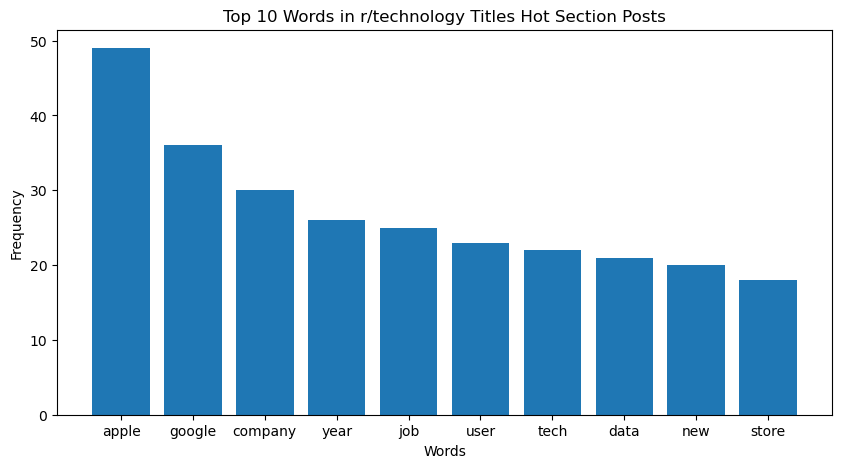

In [6]:
import matplotlib.pyplot as plt
words, frequencies = zip(*word_frequencies.most_common(10))
plt.figure(figsize=(10, 5))
plt.bar(words, frequencies)
plt.title('Top 10 Words in r/technology Titles Hot Section Posts')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

NLTK’s pos_tag function filters out non-noun words, and WordNetLemmatizer groups similar words together.

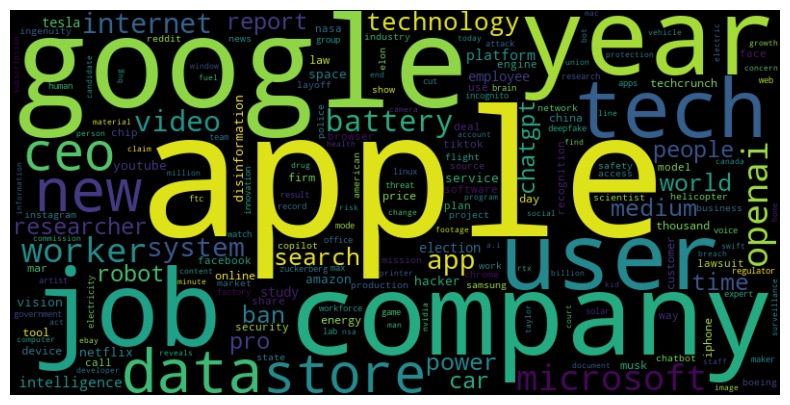

In [7]:
from wordcloud import WordCloud
word_freq_dict = dict(word_frequencies)
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\mahik\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [9]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\mahik\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
def custom_preprocessor(text):
    text = text.lower()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

titles = [post.title for post in hot_posts]
vectorizer = TfidfVectorizer(stop_words='english', preprocessor=custom_preprocessor)
vectorizer.fit(titles)
response = vectorizer.transform(titles)
feature_names = vectorizer.get_feature_names_out()
indices = response.toarray().sum(axis=0).argsort()[-10:]
top_words = [feature_names[i] for i in indices]

print(top_words)

C:\Users\mahik\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(


['eu', 'company', 'job', 'tech', 'year', 'google', 'say', 'new', 'apple', 'ai']


Here, TfidfVectorizer was used to convert the titles into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features. It is a numerical statistic that reflects how important a word is to a document in a collection or corpus. Then the top 10 words with the highest TF-IDF scores are identified across all titles.

The second code snippet is identifying the most “important” words (according to TF-IDF), while the first snippet is identifying the most “common” nouns.

Both methods give similar results for this subreddit, but can vary widely. 

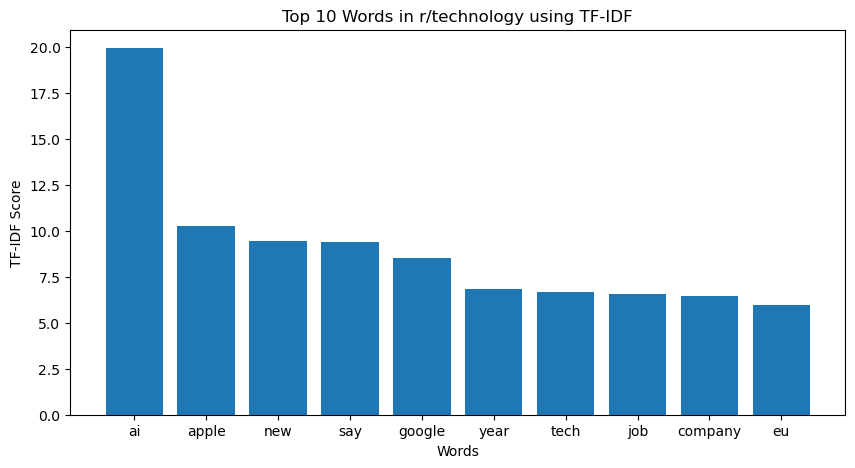

In [11]:
import matplotlib.pyplot as plt

word_sums = response.sum(axis=0)
word_frequencies = [(word, word_sums[0, idx]) for word, idx in vectorizer.vocabulary_.items() if word in top_words]
word_frequencies.sort(key=lambda x: x[1], reverse=True)

words, frequencies = zip(*word_frequencies)
plt.figure(figsize=(10, 5))
plt.bar(words, frequencies)
plt.title('Top 10 Words in r/technology using TF-IDF')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.show()

In [12]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mahik\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Sentiment Analysis

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
for title in titles:
    print(title)
    print(sia.polarity_scores(title))

23andMe admits hackers stole raw genotype data - and that cyberattack went undetected for months | Firm says it didn't realize customers were being hacked
{'neg': 0.104, 'neu': 0.811, 'pos': 0.085, 'compound': -0.128}
Lucid CEO: $50,000 Model 3, Model Y Competitor Coming Sooner Than You Think
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
White House calls for legislation after ‘alarming’ proliferation of Taylor Swift deepfakes — Social media networks also need to do more to prevent the spread of the images, said press secretary Karine Jean-Pierre
{'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'compound': 0.2911}
NSA finally admits to spying on Americans by purchasing sensitive data
{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compound': 0.296}
Elon Musk warns Tesla workers they'll be sleeping on the production line to build its new mass-market EV
{'neg': 0.076, 'neu': 0.924, 'pos': 0.0, 'compound': -0.1027}
We Asked A.I. to Create the Joker. It Generated a Copyrighted Image.
{'neg': 0.0, 

This uses SentimentIntensityAnalyzer to analyse the sentiment of each title in the titles list. 
sia.polarity_scores(title) calculates the sentiment scores for the given title. It returns a dictionary with four items: ‘neg’, ‘neu’, ‘pos’, and ‘compound’.

‘neg’, ‘neu’, and ‘pos’ represent the proportions of text that fall into negative, neutral, and positive categories respectively.
‘compound’ is a single metric that calculates the sum of all lexicon ratings and normalizes it between -1 (most extreme negative) and +1 (most extreme positive).

This can be bad at identifying nuances, for instance: 
` Taylor Swift is living every woman’s AI porn nightmare — Deepfake nudes of the pop star are appearing all over social media. We all saw this coming.
{'neg': 0.0, 'neu': 0.933, 'pos': 0.067, 'compound': 0.2023} `
It assigns it a neutral/positive score, even though it is negative-coded post title.
This is because it uses a bag-of-words approach, so it analyses the sentiment based on individual words, not taking into account the context or the order of the words. The analyser might be picking up on words like “living” and “star”.


### Topic-Specific Sentiment Analysis

In [14]:
posts = list(reddit.subreddit('technology').new(limit=1000))
topic_posts = [post for post in posts if 'ai' in post.title.lower()]
titles = [post.title for post in topic_posts]
words = []
for title in titles:
    for word in word_tokenize(title):
        words.append(word.lower())
filtered_words = [word for word in words if word not in stopwords.words('english') and word not in string.punctuation and len(word) > 2]
sia = SentimentIntensityAnalyzer()
sentiments = [sia.polarity_scores(title) for title in titles]
for title, sentiment in zip(titles, sentiments):
    print(f'Title: {title}')
    print(f'Sentiment: {sentiment}')

Title: AI Discovers New Material That Could Slash Lithium Use In Batteries
Sentiment: {'neg': 0.174, 'neu': 0.826, 'pos': 0.0, 'compound': -0.2732}
Title: White House calls for legislation after ‘alarming’ proliferation of Taylor Swift deepfakes — Social media networks also need to do more to prevent the spread of the images, said press secretary Karine Jean-Pierre
Sentiment: {'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'compound': 0.2911}
Title: Paris accuses Russia of waging disinformation campaign against France
Sentiment: {'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'compound': -0.34}
Title: A new AI model called Morpheus-1 claims to induce lucid dreaming
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Title: Tech companies are slashing thousands of jobs as they pivot toward AI
Sentiment: {'neg': 0.16, 'neu': 0.84, 'pos': 0.0, 'compound': -0.2732}
Title: How Extreme Weather & System Aging Affect the US Solar Photovoltaic Fleet
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0

In [15]:
positive = sum(1 for sentiment in sentiments if sentiment['compound'] > 0.05)
neutral = sum(1 for sentiment in sentiments if -0.05 <= sentiment['compound'] <= 0.05)
negative = sum(1 for sentiment in sentiments if sentiment['compound'] < -0.05)

print(f"Positive sentiments: {positive}")
print(f"Neutral sentiments: {neutral}")
print(f"Negative sentiments: {negative}")

Positive sentiments: 76
Neutral sentiments: 88
Negative sentiments: 81


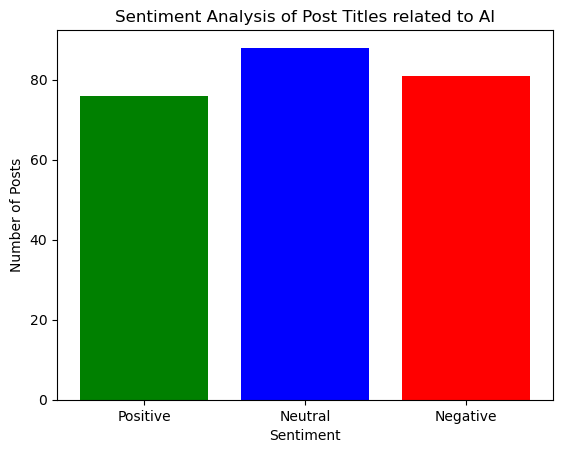

In [24]:
import matplotlib.pyplot as plt

sentiments = ['Positive', 'Neutral', 'Negative']
counts = [76, 88, 81]

plt.bar(sentiments, counts, color=['green', 'blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.title('Sentiment Analysis of Post Titles related to AI')
plt.show()

In [17]:
import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

sentiments = [sia.polarity_scores(post.title)['compound'] for post in topic_posts]
creation_times = [datetime.datetime.utcfromtimestamp(post.created_utc).hour for post in topic_posts]

posts_by_hour = [[] for _ in range(24)]
for creation_time, sentiment in zip(creation_times, sentiments):
    posts_by_hour[creation_time].append(sentiment)

average_sentiment_by_hour = [sum(hour_posts) / len(hour_posts) if hour_posts else 0 for hour_posts in posts_by_hour]

for hour, average_sentiment in enumerate(average_sentiment_by_hour):
    print(f"Hour: {hour}")
    print(f"Average Sentiment: {average_sentiment}\n")

Hour: 0
Average Sentiment: 0.023569999999999997

Hour: 1
Average Sentiment: 0.5796

Hour: 2
Average Sentiment: 0.11292666666666669

Hour: 3
Average Sentiment: 0.06735714285714287

Hour: 4
Average Sentiment: 0.08231666666666666

Hour: 5
Average Sentiment: -0.04638333333333333

Hour: 6
Average Sentiment: -0.07906363636363635

Hour: 7
Average Sentiment: -0.22367142857142858

Hour: 8
Average Sentiment: -0.16814615384615383

Hour: 9
Average Sentiment: 0.05260909090909092

Hour: 10
Average Sentiment: 0.250825

Hour: 11
Average Sentiment: -0.32084444444444443

Hour: 12
Average Sentiment: 0.1599611111111111

Hour: 13
Average Sentiment: 0.004175000000000012

Hour: 14
Average Sentiment: 0.08702307692307695

Hour: 15
Average Sentiment: 0.11548333333333331

Hour: 16
Average Sentiment: -0.04576666666666665

Hour: 17
Average Sentiment: -0.2582666666666667

Hour: 18
Average Sentiment: -0.10338333333333333

Hour: 19
Average Sentiment: -0.04344285714285715

Hour: 20
Average Sentiment: -0.08476923076923

The sentiment of the posts varies throughout the day.

In [18]:
from collections import defaultdict

# Group posts by number of comments
posts_by_num_comments = defaultdict(list)
for post in topic_posts:
    posts_by_num_comments[post.num_comments].append(post)

average_sentiment_by_num_comments = {}
for num_comments, posts in posts_by_num_comments.items():
    sentiments = [sia.polarity_scores(post.title)['compound'] for post in posts]
    average_sentiment_by_num_comments[num_comments] = sum(sentiments) / len(sentiments)
for num_comments, average_sentiment in average_sentiment_by_num_comments.items():
    print(f"Number of Comments: {num_comments}")
    print(f"Average Sentiment: {average_sentiment}\n")

Number of Comments: 30
Average Sentiment: -0.1366

Number of Comments: 320
Average Sentiment: 0.2911

Number of Comments: 2
Average Sentiment: 0.043541666666666645

Number of Comments: 19
Average Sentiment: 0.3399

Number of Comments: 237
Average Sentiment: -0.2732

Number of Comments: 1
Average Sentiment: -0.03573529411764705

Number of Comments: 54
Average Sentiment: 0.4404

Number of Comments: 3
Average Sentiment: 0.06985000000000001

Number of Comments: 6
Average Sentiment: -0.0553142857142857

Number of Comments: 52
Average Sentiment: 0.128

Number of Comments: 4
Average Sentiment: 0.09243000000000001

Number of Comments: 0
Average Sentiment: -0.006066666666666665

Number of Comments: 5
Average Sentiment: 0.4379

Number of Comments: 350
Average Sentiment: 0.7717

Number of Comments: 28
Average Sentiment: -0.08940000000000001

Number of Comments: 4157
Average Sentiment: 0.2023

Number of Comments: 25
Average Sentiment: -0.7146

Number of Comments: 990
Average Sentiment: -0.25

Numb

In [19]:
sorted_posts = sorted(topic_posts, key=lambda post: post.num_comments, reverse=True)
top_posts = sorted_posts[:10]
top_sentiments = [sia.polarity_scores(post.title)['compound'] for post in top_posts]
for post, sentiment in zip(top_posts, top_sentiments):
    print(f"Title: {post.title}")
    print(f"Number of Comments: {post.num_comments}")
    print(f"Sentiment: {sentiment}\n")

Title: Taylor Swift is living every woman’s AI porn nightmare — Deepfake nudes of the pop star are appearing all over social media. We all saw this coming.
Number of Comments: 4157
Sentiment: 0.2023

Title: YouTube is loading slower for users with ad blockers yet again
Number of Comments: 1775
Sentiment: 0.0

Title: AI-Generated George Carlin Drops Comedy Special That Daughter Speaks Out Against: ‘No Machine Will Ever Replace His Genius’
Number of Comments: 1763
Sentiment: 0.6369

Title: Formula E team fires its AI-generated female motorsports reporter, after backlash: “What a slap in the face for human women that you’d rather make one up than work with us.”
Number of Comments: 1486
Sentiment: 0.1531

Title: Nightshade, the free tool that ‘poisons’ AI models, is now available for artists to use
Number of Comments: 1189
Sentiment: 0.5106

Title: Google is getting worse as it loses its fight against search engine spam
Number of Comments: 1187
Sentiment: -0.8591

Title: Trolls have floode

 Both polarising, as well as neutral posts which contain information about recent developments have a high number of comments.

### Sentiment Over Time

In [20]:
import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
sentiments = [sia.polarity_scores(post.title)['compound'] for post in topic_posts]
creation_times = [datetime.date.fromtimestamp(post.created_utc) for post in topic_posts]

posts_by_day = {}
for creation_time, sentiment in zip(creation_times, sentiments):
    if creation_time not in posts_by_day:
        posts_by_day[creation_time] = []
    posts_by_day[creation_time].append(sentiment)

average_sentiment_by_day = {day: sum(day_posts) / len(day_posts) for day, day_posts in posts_by_day.items()}
sorted_sentiment_by_day = dict(sorted(average_sentiment_by_day.items()))

for day, average_sentiment in sorted_sentiment_by_day.items():
    print(f"Date: {day}")
    print(f"Average Sentiment: {average_sentiment}\n")

Date: 2024-01-10
Average Sentiment: -0.19166666666666662

Date: 2024-01-11
Average Sentiment: 0.09569523809523808

Date: 2024-01-12
Average Sentiment: -0.1603

Date: 2024-01-13
Average Sentiment: 0.06506666666666668

Date: 2024-01-14
Average Sentiment: 0.005199999999999994

Date: 2024-01-15
Average Sentiment: -0.04147142857142856

Date: 2024-01-16
Average Sentiment: 0.08721999999999999

Date: 2024-01-17
Average Sentiment: -0.058585714285714297

Date: 2024-01-18
Average Sentiment: 0.01163529411764707

Date: 2024-01-19
Average Sentiment: -0.006946666666666686

Date: 2024-01-20
Average Sentiment: -0.0692

Date: 2024-01-21
Average Sentiment: -0.0896

Date: 2024-01-22
Average Sentiment: -0.005308333333333332

Date: 2024-01-23
Average Sentiment: -0.11574166666666667

Date: 2024-01-24
Average Sentiment: 0.030677272727272716

Date: 2024-01-25
Average Sentiment: -0.12315

Date: 2024-01-26
Average Sentiment: 0.0945125

Date: 2024-01-27
Average Sentiment: -0.10736666666666667



### Correlation between Sentiments with Comments and Upvotes

In [21]:
import numpy as np
from scipy.stats import pearsonr
sentiments = [sia.polarity_scores(post.title)['compound'] for post in topic_posts]
upvotes = [post.score for post in topic_posts]
comments = [post.num_comments for post in topic_posts]
corr_upvotes, _ = pearsonr(sentiments, upvotes)
print(f"Correlation between sentiment and upvotes: {corr_upvotes}")
corr_comments, _ = pearsonr(sentiments, comments)
print(f"Correlation between sentiment and comments: {corr_comments}")

Correlation between sentiment and upvotes: -0.03405407393594097
Correlation between sentiment and comments: -0.008712349906065932


Based on this analysis, the sentiment of the posts doesn’t seem to have a strong linear relationship with either the number of upvotes or comments they receive.

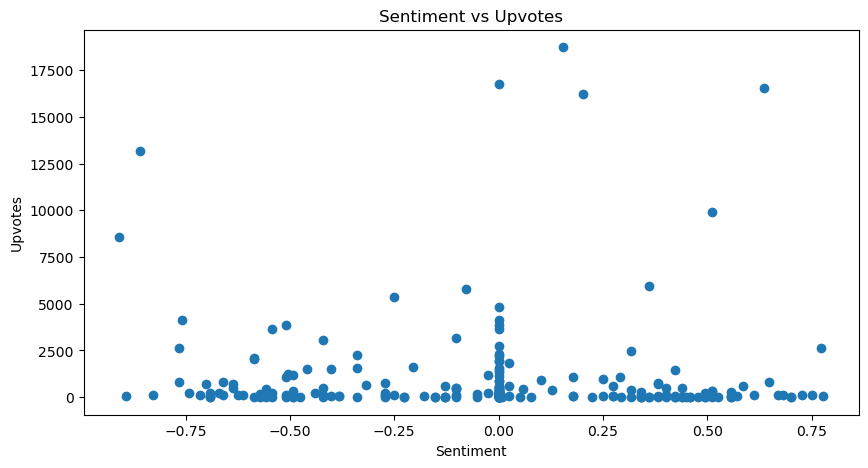

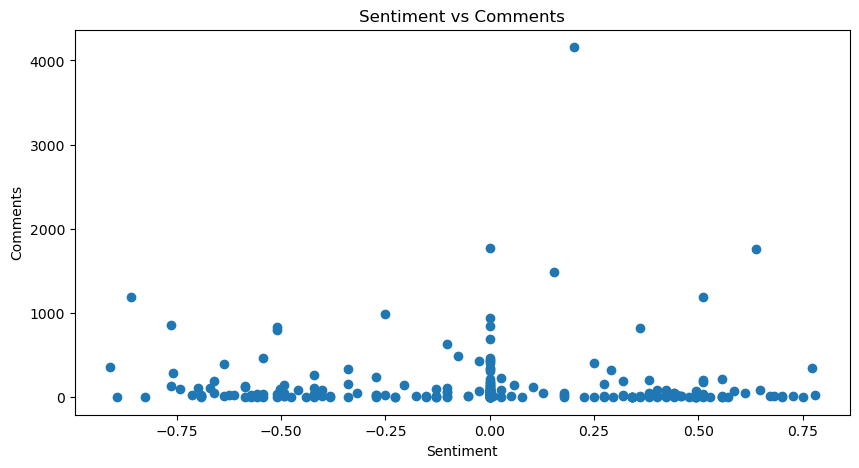

In [22]:
plt.figure(figsize=(10, 5))
plt.scatter(sentiments, upvotes)
plt.title('Sentiment vs Upvotes')
plt.xlabel('Sentiment')
plt.ylabel('Upvotes')
plt.show()
plt.figure(figsize=(10, 5))
plt.scatter(sentiments, comments)
plt.title('Sentiment vs Comments')
plt.xlabel('Sentiment')
plt.ylabel('Comments')
plt.show()

In [23]:
subreddit = reddit.subreddit('technology')
hot_posts = subreddit.hot(limit=10)
for post in top_posts:
    print(f"Post: {post.title}")
    for comment in post.comments.list():
        if isinstance(comment, praw.models.MoreComments):
            continue
        sentiment = sia.polarity_scores(comment.body)
        print(f"Comment: {comment.body[:50]}") 
        print(f"Sentiment: {sentiment}\n")

Post: Taylor Swift is living every woman’s AI porn nightmare — Deepfake nudes of the pop star are appearing all over social media. We all saw this coming.
Comment: Today I learned: people don't know deepfakes exist
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Comment: isn't there already like 30 pornstar look a likes 
Sentiment: {'neg': 0.167, 'neu': 0.652, 'pos': 0.18, 'compound': 0.0947}

Comment: Unfortunately this isn't a new thing for Taylor Sw
Sentiment: {'neg': 0.082, 'neu': 0.856, 'pos': 0.062, 'compound': -0.1531}

Comment: I suppose the only silver lining is that if real n
Sentiment: {'neg': 0.134, 'neu': 0.866, 'pos': 0.0, 'compound': -0.4767}

Comment: >we saw this coming


No shit. There were fake cel
Sentiment: {'neg': 0.331, 'neu': 0.669, 'pos': 0.0, 'compound': -0.836}

Comment: The daily "We need to regulate AI out of the hands
Sentiment: {'neg': 0.0, 'neu': 0.923, 'pos': 0.077, 'compound': 0.4404}

Comment: Excerpt:

*On Thursday afternoon, the Sw

In [56]:
title_sentiments = []
comment_sentiments = []

for post in top_posts:
    title_sentiments.append(sia.polarity_scores(post.title)['compound'])
    
    for comment in post.comments.list():
        if isinstance(comment, praw.models.MoreComments):
            continue
        comment_sentiments.append(sia.polarity_scores(comment.body)['compound'])

average_title_sentiment = sum(title_sentiments) / len(title_sentiments) if title_sentiments else 0
average_comment_sentiment = sum(comment_sentiments) / len(comment_sentiments) if comment_sentiments else 0
print(f"Average title sentiment: {average_title_sentiment}")
print(f"Average comment sentiment: {average_comment_sentiment}")

Average title sentiment: -0.037119999999999986
Average comment sentiment: 0.04164975599837333


In [26]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
title_sentiments = [sia.polarity_scores(title)['compound'] for title in titles]
subreddit = reddit.subreddit('technology')
hot_posts = subreddit.hot(limit=10)
comment_sentiments = []
for post in hot_posts:
    for comment in post.comments.list():
        if isinstance(comment, praw.models.MoreComments):
            continue
        comment_sentiments.append(sia.polarity_scores(comment.body)['compound'])


average_title_sentiment = sum(title_sentiments) / len(title_sentiments) if title_sentiments else 0
average_comment_sentiment = sum(comment_sentiments) / len(comment_sentiments) if comment_sentiments else 0
print(f"Average title sentiment: {average_title_sentiment}")
print(f"Average comment sentiment: {average_comment_sentiment}")

Average title sentiment: -0.016844489795918367
Average comment sentiment: 0.052576370997423585


# Network Analysis

In [35]:
import networkx as nx

G = nx.DiGraph()
for post in subreddit.hot(limit=10):
    if post.author is None:
        continue
    for comment in post.comments.list():
        if isinstance(comment, praw.models.MoreComments):
            continue
        if comment.author is not None and comment.author != post.author:
            G.add_edge(post.author, comment.author)

degree_centrality = nx.degree_centrality(G)
print("Degree Centrality:", degree_centrality)

in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
print("In-Degree Centrality:", in_degree_centrality)
print("Out-Degree Centrality:", out_degree_centrality)

eigenvector_centrality = nx.eigenvector_centrality(G)
print("Eigenvector Centrality:", eigenvector_centrality)

clustering_coefficient = nx.average_clustering(G)
print("Average Clustering Coefficient:", clustering_coefficient)

graph_density = nx.density(G)
print("Graph Density:", graph_density)

Degree Centrality: {Redditor(name='marketrent'): 0.1772151898734177, Redditor(name='goneinfo'): 0.0005274261603375527, Redditor(name='Send-Me-Tiddies-PLS'): 0.0005274261603375527, Redditor(name='getshrektdh'): 0.0005274261603375527, Redditor(name='KennyDROmega'): 0.0010548523206751054, Redditor(name='zeroconflicthere'): 0.0005274261603375527, Redditor(name='adamusprime'): 0.0005274261603375527, Redditor(name='EmbarrassedHelp'): 0.0010548523206751054, Redditor(name='GhostRiders'): 0.0005274261603375527, Redditor(name='Tottie3'): 0.0005274261603375527, Redditor(name='basscycles'): 0.0005274261603375527, Redditor(name='erdermereremoulade'): 0.0005274261603375527, Redditor(name='CyndiIsOnReddit'): 0.0005274261603375527, Redditor(name='Rocketsloth'): 0.0005274261603375527, Redditor(name='moshdagoat'): 0.0005274261603375527, Redditor(name='ArtOfSmokeAndMirrors'): 0.0010548523206751054, Redditor(name='teddittsch'): 0.0005274261603375527, Redditor(name='Carcharis'): 0.0005274261603375527, Redd

This value of graph density indicates that only a small fraction of all possible interactions between users in the subreddit are actually happening.

### Community Analysis

In [36]:
conda install python-louvain

Channels:
 - defaults
 - conda-forge
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [40]:
from community import community_louvain
G_undirected = G.to_undirected()
communities = community_louvain.best_partition(G_undirected)
print(communities)

{Redditor(name='marketrent'): 0, Redditor(name='goneinfo'): 0, Redditor(name='Send-Me-Tiddies-PLS'): 0, Redditor(name='getshrektdh'): 0, Redditor(name='KennyDROmega'): 1, Redditor(name='zeroconflicthere'): 0, Redditor(name='adamusprime'): 0, Redditor(name='EmbarrassedHelp'): 2, Redditor(name='GhostRiders'): 0, Redditor(name='Tottie3'): 0, Redditor(name='basscycles'): 0, Redditor(name='erdermereremoulade'): 0, Redditor(name='CyndiIsOnReddit'): 0, Redditor(name='Rocketsloth'): 0, Redditor(name='moshdagoat'): 0, Redditor(name='ArtOfSmokeAndMirrors'): 3, Redditor(name='teddittsch'): 0, Redditor(name='Carcharis'): 0, Redditor(name='adampsyreal'): 0, Redditor(name='ArScrap'): 0, Redditor(name='TAC1313'): 0, Redditor(name='MarlboroBoi'): 0, Redditor(name='agent0range'): 0, Redditor(name='Ctsanger'): 0, Redditor(name='ineedthemeatinme'): 0, Redditor(name='zigiboogieduke'): 0, Redditor(name='BenzotheWicked'): 0, Redditor(name='thelingererer'): 0, Redditor(name='greenbroad-gc'): 0, Redditor(name

In [41]:
from collections import defaultdict
communities_inverted = defaultdict(list)
for user, community_id in communities.items():
    communities_inverted[community_id].append(user)
for community_id, users in communities_inverted.items():
    print(f"Community {community_id}:")
    for user in users:
        print(user)
    print("\n")

Community 0:
marketrent
goneinfo
Send-Me-Tiddies-PLS
getshrektdh
zeroconflicthere
adamusprime
GhostRiders
Tottie3
basscycles
erdermereremoulade
CyndiIsOnReddit
Rocketsloth
moshdagoat
teddittsch
Carcharis
adampsyreal
ArScrap
TAC1313
MarlboroBoi
agent0range
Ctsanger
ineedthemeatinme
zigiboogieduke
BenzotheWicked
thelingererer
greenbroad-gc
Zealousideal-Wear271
TheHistorian2
gow3st
ThatColinRobinson
Lightspeedius
noogers
didsomebodysaymyname
AbyssFren
StoryNo1430
JakesInSpace
TECHNIK23
calvin43
Yaibakai
confusedpsyduck69
TrainsDontHunt
ZealousWolverine
aquarain
Random_dude2469
Mission_Fix5608
Msbaubles
KountMacula
rourobouros
Modroidz
Desk46
bkr1895
Outside_Interest4959
SilentShallot729
ChronicallyPunctual
ghostnote_ninja
Witty_Interaction_77
Wallachia87
blobhole
Sushrit_Lawliet
RevivedMisanthropy
Foreverwideright1991
xdeltax97
Humble-Audience7340
Miguelwastaken
Lawmonger
Morden013
Professional-Bored
veryworst
SourLoafBaltimore
JoshSidekick
sakura608
MapPsychological2136
Ok_Series_4580
99

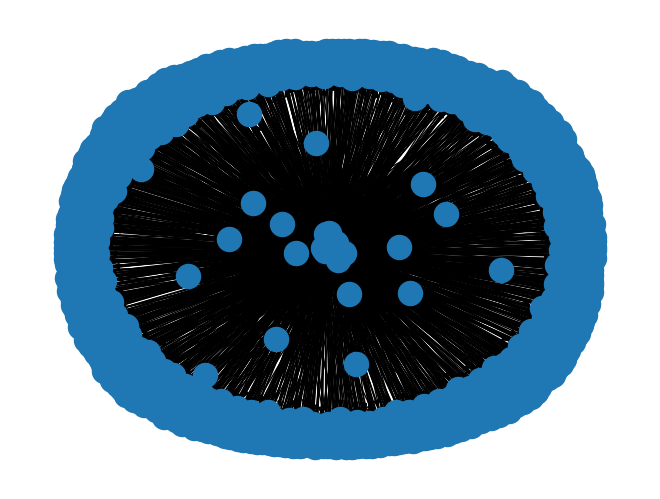

In [44]:
nx.draw(G)

The network is too large, so no comprehensible inferences can be deduced from this.

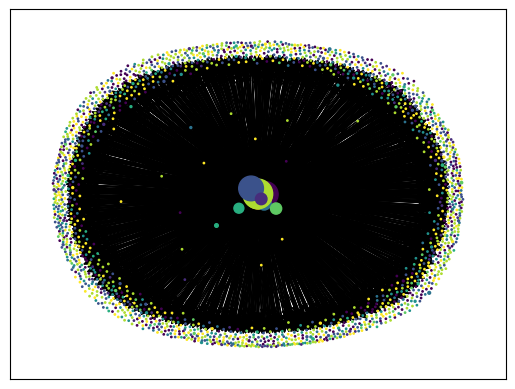

In [45]:
import matplotlib.pyplot as plt

degree = dict(G.degree())
communities = community_louvain.best_partition(G.to_undirected())
layout = nx.spring_layout(G)
nx.draw_networkx_nodes(G, layout, communities.keys(), node_size=[degree[node] for node in G], node_color=list(communities.values()))

nx.draw_networkx_edges(G, layout)
plt.show()

In the above graph, nodes are colored by their community and sized by their degree. It looks more understandable than the previous graph, but it is still too large of a network to give coherant results. 

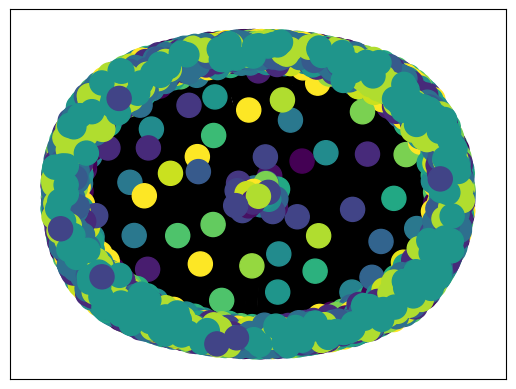

In [47]:
from community import community_louvain

keywords = ["Apple", "iPhone", "Mac", "iOS", "iPad", "MacBook"]
G1 = nx.DiGraph()

for post in subreddit.hot(limit=1000):
    if any(keyword in post.title for keyword in keywords):
        for comment in post.comments.list():
            if isinstance(comment, praw.models.MoreComments):
                continue
            if comment.author is not None and comment.author != post.author:
                G1.add_edge(post.author, comment.author)

G1_undirected = G1.to_undirected()
communities = community_louvain.best_partition(G1_undirected)
layout = nx.spring_layout(G1)
nx.draw_networkx_nodes(G1, layout, communities.keys(), node_color=list(communities.values()))
nx.draw_networkx_edges(G1, layout)
plt.show()

The colors represent different communities detected by the Louvain method. Users in the same community have more interactions with each other.
The size of the nodes represents their degree (the number of interactions they have). Larger nodes are users who have interacted with more other users. These might be particularly active or influential users in the subreddit.